In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [58]:
img = cv2.imread("lena.jpg")
# Converting BGR color to RGB color format
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
R, G, B = cv2.split(RGB_img)

#img_merged = cv2.merge((R, G, B))
#plt.imshow(img_merged)
# plt.imshow(R, cmap="Reds")
# plt.imshow(G, cmap="Greens")
# plt.imshow(B, cmap="Blues")

In [97]:
def apply_correlation(matrix, filter):
    h, w =  filter.shape
    h = int(h / 2)
    w = int(w / 2)

    matrix_result = []
    for i in range(h, matrix.shape[0] - h):
        columns = []
        for j in range(w, matrix.shape[1] - w):
            # Frobenius dot product of the pixel i,j
            sum = 0
            for k in range(-w, w + 1):
                for l in range(-h, h + 1):
                    sum+= matrix[i + k][j + l] * filter[k + h][l + w]

            # pixel result
            # rows assignment
            columns.append(int(sum))

        # rows stack
        matrix_result.append(columns)

    return np.array(matrix_result)        

In [106]:
filter_box = np.array([
    [1 / 9, 1 / 9, 1 / 9],
    [1 / 9, 1 / 9, 1 / 9],
    [1 / 9, 1 / 9, 1 / 9]
])

# matrix = np.array([
#     [1, 1, 1],
#     [1, 1, 1],
#     [1, 1, 1]
# ])

In [107]:
filter_box.shape

(3, 3)

In [108]:
R_box = apply_correlation(R, filter_box)
G_box = apply_correlation(G, filter_box)
B_box = apply_correlation(B, filter_box)

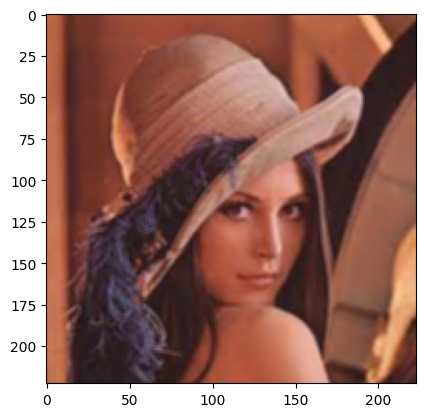

In [109]:
img_merged = cv2.merge((R_box, G_box, B_box))
plt.imshow(img_merged)